In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import random
from six.moves import cPickle as pickle
%matplotlib inline


In [2]:
from tensorflow.examples.tutorials.mnist import input_data

In [3]:
mnist = input_data.read_data_sets('MNIST_data', one_hot = True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [4]:
type(mnist)

tensorflow.contrib.learn.python.learn.datasets.base.Datasets

In [5]:
mnist.train

In [107]:
mnist.train.labels.shape


(55000, 10)

In [25]:
a = mnist.train.images[7]
b = mnist.train.images[2]
a = a.reshape(28,28)
b = b.reshape(28,28)
c = np.zeros((28,28))
d = np.concatenate((a,b,c),axis = 1)

In [194]:
print mnist.train.images.shape,mnist.test.images.shape,mnist.validation.images.shape

(55000, 784) (10000, 784) (5000, 784)


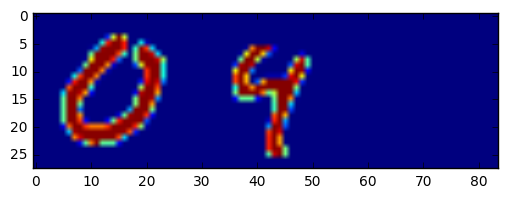

In [26]:
plt.imshow(d)
plt.show()

In [196]:
def Generate_dataset(original_dataset, dataset_size, max_length):
    labels_list = list()
    data_list = list()
    original_size = original_dataset.images.shape[0]
    for i in range(max_length):
        labels_list.append([])
    for i in range(dataset_size):
        num_length = random.randint(1, max_length)
        tmp = list()
        for j in range(max_length):
            if j < num_length:
                index = random.randint(0, original_size - 1)
#                 print index
                tmp.append(original_dataset.images[index].reshape(28,28))
                data_label = np.concatenate((original_dataset.labels[index], np.array([0])), axis = 0)
                labels_list[j].append(data_label.tolist())
                
            else:
                tmp.append(np.zeros((28,28)))
                data_label = np.concatenate((np.zeros(10), np.array([1])), axis=0)
                labels_list[j].append(data_label.tolist())
        data_list.append(np.concatenate(tmp, axis = 1).reshape((1, 28 * 28 * max_length)))
    labels_list = [np.array(i) for i in labels_list]
        
    return np.concatenate(data_list, axis = 0), labels_list
        
                
        
    
    

In [30]:
def one_hot(num_length):
    label_num = [0,0,0,0,0]
    label_num[num_length - 1] = 1
    return label_num

def Generate_dataset_1(original_dataset, dataset_size, max_length):
    labels_list = list()
    data_list = list()
    labels = list()
    label_seqno = list()
    original_size = original_dataset.images.shape[0]
    for i in range(max_length + 1):
        labels_list.append([])
    for i in range(dataset_size):
        num_length = random.randint(1, max_length)
        label_seqno.append(num_length)
        labels_list[0].append(one_hot(num_length))
        tmp = list()
        label_tmp = []
        for j in range(max_length):
            if j < num_length:
                index = random.randint(0, original_size - 1)
#                 print index
                tmp.append(original_dataset.images[index].reshape(28,28))
                data_label = original_dataset.labels[index]
                labels_list[j + 1].append(data_label.tolist())
                label_tmp.append(np.argmax(data_label).tolist())
                
            else:
                tmp.append(np.zeros((28,28)))
                data_label = np.zeros(10)
                labels_list[j + 1].append(data_label.tolist())
                label_tmp.append(11)
        data_list.append(np.concatenate(tmp, axis = 1).reshape((1, 28 * 28 * max_length)))
        labels.append(label_tmp)
    labels_list = [np.array(i) for i in labels_list]
        
    return np.concatenate(data_list, axis = 0), labels_list, np.array(labels), np.array(label_seqno)
        
                
        
    
    

In [197]:
train_dataset, train_labels = Generate_dataset(mnist.train,55000,5)
valid_dataset, valid_labels = Generate_dataset(mnist.validation,5000,5)
test_dataset, test_labels = Generate_dataset(mnist.test,10000,5)

In [31]:
train_dataset_ref, train_labels_ref, t_l,t_n = Generate_dataset_1(mnist.train,55000,5)
valid_dataset_ref, valid_labels_ref,v_l,v_n = Generate_dataset_1(mnist.validation,5000,5)
test_dataset_ref, test_labels_ref,te_l,te_n = Generate_dataset_1(mnist.test,10000,5)

In [32]:
test =train_dataset_ref[1].reshape(28,140)

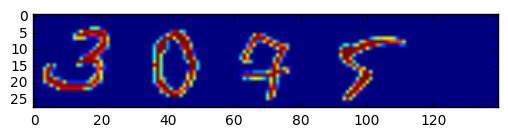

In [33]:
plt.imshow(test)

In [34]:
t_n[1]

4

In [100]:
pickle_file = 'sequence_ref.pickle'
try:
  with open(pickle_file, 'wb') as f:
      save = {
        'train_dataset_ref': train_dataset_ref,
        'train_labels_ref': train_labels_ref,
        'valid_dataset_ref': valid_dataset_ref,
        'valid_labels_ref': valid_labels_ref,
        'test_dataset_ref': test_dataset_ref,
        'test_labels_ref': test_labels_ref,
        }
      pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)

except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise


In [62]:
pickle_file = 'sequence.pickle'
try:
    with open(pickle_file, 'rb') as f:
        dataset_dict = pickle.load(f)
        train_dataset = dataset_dict['train_dataset']
        test_dataset = dataset_dict['test_dataset']
        train_labels = dataset_dict['train_labels']
        valid_dataset = dataset_dict['valid_dataset']
        valid_labels = dataset_dict['valid_labels']
        test_labels = dataset_dict['test_labels']
    
except Exception as e:
    print ('Unable to load the data')
    raise

In [65]:
image_size = 28
num_labels = 10
num_channels = 1 # grayscale
def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size * 5, num_channels)).astype(np.float32)
  return dataset
train_dataset = reformat(train_dataset, train_labels)
valid_dataset = reformat(valid_dataset, valid_labels)
test_dataset = reformat(test_dataset, test_labels)
print('Training set', train_dataset.shape)
print('Validation set', valid_dataset.shape)
print('Test set', test_dataset.shape)

('Training set', (55000, 28, 140, 1))
('Validation set', (5000, 28, 140, 1))
('Test set', (10000, 28, 140, 1))


In [69]:
test = test_dataset[100]
print test_labels[1].shape

(10000, 11)


In [70]:
batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64
max_length = 5
num_labels = 11



In [7]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
      return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
      return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')
def accuracy(predictions, labels):
    accur = 0
    for index, item in enumerate(predictions):
        accur += np.sum(np.argmax(item, 1) == np.argmax(labels[index], 1))
#         print accur
#         print item.shape
    return (100.0 * accur / float(len(predictions) * predictions[0].shape[0]))
        
 

In [71]:
keep_prob = 0.5
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size, image_size * 5, num_channels))
    tf_train_labels = list()
    for _ in range(max_length):
        tf_train_labels.append(tf.placeholder(tf.float32, shape = (batch_size, num_labels)))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth])
    layer1_bias = bias_variable([depth])
    layer2_weights = weight_variable([patch_size, patch_size, depth, depth])
    layer2_bias = bias_variable([depth])
    layer3_weights = weight_variable([image_size // 4 * image_size *5 // 4 * depth, num_hidden])
    layer3_bias = bias_variable([num_hidden])
    s1_w = weight_variable([num_hidden,num_labels])
    s1_b = bias_variable([num_labels])
    s2_w = weight_variable([num_hidden,num_labels])
    s2_b = bias_variable([num_labels])
    s3_w = weight_variable([num_hidden,num_labels])
    s3_b = bias_variable([num_labels])
    s4_w = weight_variable([num_hidden,num_labels])
    s4_b = bias_variable([num_labels])
    s5_w = weight_variable([num_hidden,num_labels])
    s5_b = bias_variable([num_labels])
    
    def model(data,train_only = True):
        conv = conv2d(data, layer1_weights)
        hidden_1 = tf.nn.relu(conv + layer1_bias)
        h_pool_1 = max_pool_2x2(hidden_1)
        if train_only:
            h_pool_1 = tf.nn.dropout(h_pool_1,keep_prob)
        conv = conv2d(h_pool_1, layer2_weights)
        hidden_2 = tf.nn.relu(conv + layer2_bias)
        h_pool_2 = max_pool_2x2(hidden_2)
        if train_only:
            h_pool_2 = tf.nn.dropout(h_pool_2,keep_prob)
        shape = h_pool_2.get_shape().as_list()
#         print type(shape)
#         print shape
        reshape = tf.reshape(h_pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_bias)
        if train_only:
            hidden = tf.nn.dropout(hidden,keep_prob)
        logits1 = tf.matmul(hidden, s1_w) + s1_b
        logits2 = tf.matmul(hidden, s2_w) + s2_b
        logits3 = tf.matmul(hidden, s3_w) + s3_b
        logits4 = tf.matmul(hidden, s4_w) + s4_b
        logits5 = tf.matmul(hidden, s5_w) + s5_b

        return [logits1,logits2,logits3,logits4,logits5]
    
    # Training computation.
    logits= model(tf_train_dataset)
    logits_train = model(tf_train_dataset,False)
    logits_valid = model(tf_valid_dataset, False)
    logits_test = model(tf_test_dataset, False)
    loss = 0
    for i in range(max_length):
        loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels[i], logits=logits[i])) 

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.

    train_prediction = tf.stack((tf.nn.softmax(logits_train[0]), tf.nn.softmax(logits_train[1]), tf.nn.softmax(logits_train[2]), \
                                 tf.nn.softmax(logits_train[3]), tf.nn.softmax(logits_train[4])))
    valid_prediction = tf.stack((tf.nn.softmax(logits_valid[0]), tf.nn.softmax(logits_valid[1]), tf.nn.softmax(logits_valid[2]),tf.nn.softmax(logits_valid[3]), tf.nn.softmax(logits_valid[4])))
    test_prediction = tf.stack((tf.nn.softmax(logits_test[0]), tf.nn.softmax(logits_test[1]), tf.nn.softmax(logits_test[2]),tf.nn.softmax(logits_test[3]), tf.nn.softmax(logits_test[4])))
    
    saver = tf.train.Saver()

In [72]:
num_steps = 10001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
    feed_dict = dict()
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    feed_dict[tf_train_dataset] = batch_data
    batch_labels = list()
    for i in range(max_length):
        batch_labels.append(train_labels[i][offset:(offset + batch_size), :])
        feed_dict[tf_train_labels[i]] = train_labels[i][offset:(offset + batch_size), :]
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
    if (step % 100 == 0):
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))
  save_path = saver.save(session, "CNN_multi.ckpt")
  print("Model saved in file: %s" % save_path)


Initialized
Minibatch loss at step 0: 31.628092
Minibatch accuracy: 15.0%
Validation accuracy: 21.7%
Minibatch loss at step 50: 7.836520
Minibatch accuracy: 45.0%
Minibatch loss at step 100: 7.846429
Minibatch accuracy: 45.0%
Validation accuracy: 45.3%
Minibatch loss at step 150: 7.362939
Minibatch accuracy: 46.2%
Minibatch loss at step 200: 9.750185
Minibatch accuracy: 30.0%
Validation accuracy: 47.2%
Minibatch loss at step 250: 7.382410
Minibatch accuracy: 48.8%
Minibatch loss at step 300: 8.045277
Minibatch accuracy: 43.8%
Validation accuracy: 51.8%
Minibatch loss at step 350: 5.696900
Minibatch accuracy: 67.5%
Minibatch loss at step 400: 6.201841
Minibatch accuracy: 62.5%
Validation accuracy: 55.8%
Minibatch loss at step 450: 5.995695
Minibatch accuracy: 58.8%
Minibatch loss at step 500: 4.603451
Minibatch accuracy: 76.2%
Validation accuracy: 55.4%
Minibatch loss at step 550: 6.294787
Minibatch accuracy: 65.0%
Minibatch loss at step 600: 7.287162
Minibatch accuracy: 62.5%
Validatio

In [329]:
print test_dataset.shape

(10000, 28, 140, 1)


In [15]:
sample_test = []
for i in range(5):
    sample_test_index = random.randint(0,9999)
    sample_test.append(sample_test_index)
    

In [16]:
test_sample = test_dataset[sample_test,:,:,:]

In [358]:
keep_prob = 0.5
graph = tf.Graph()
with graph.as_default():
    tf_test_dataset = tf.placeholder(tf.float32, shape = (5, image_size, image_size * 5, num_channels))
 
    
    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth])
    layer1_bias = bias_variable([depth])
    layer2_weights = weight_variable([patch_size, patch_size, depth, depth])
    layer2_bias = bias_variable([depth])
    layer3_weights = weight_variable([image_size // 4 * image_size *5 // 4 * depth, num_hidden])
    layer3_bias = bias_variable([num_hidden])
    s1_w = weight_variable([num_hidden,num_labels])
    s1_b = bias_variable([num_labels])
    s2_w = weight_variable([num_hidden,num_labels])
    s2_b = bias_variable([num_labels])
    s3_w = weight_variable([num_hidden,num_labels])
    s3_b = bias_variable([num_labels])
    s4_w = weight_variable([num_hidden,num_labels])
    s4_b = bias_variable([num_labels])
    s5_w = weight_variable([num_hidden,num_labels])
    s5_b = bias_variable([num_labels])
    
    def model(data,train_only = True):
        conv = conv2d(data, layer1_weights)
        hidden_1 = tf.nn.relu(conv + layer1_bias)
        h_pool_1 = max_pool_2x2(hidden_1)
        if train_only:
            h_pool_1 = tf.nn.dropout(h_pool_1,keep_prob)
        conv = conv2d(h_pool_1, layer2_weights)
        hidden_2 = tf.nn.relu(conv + layer2_bias)
        h_pool_2 = max_pool_2x2(hidden_2)
        if train_only:
            h_pool_2 = tf.nn.dropout(h_pool_2,keep_prob)
        shape = h_pool_2.get_shape().as_list()
#         print type(shape)
#         print shape
        reshape = tf.reshape(h_pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_bias)
        if train_only:
            hidden = tf.nn.dropout(hidden,keep_prob)
        logits1 = tf.matmul(hidden, s1_w) + s1_b
        logits2 = tf.matmul(hidden, s2_w) + s2_b
        logits3 = tf.matmul(hidden, s3_w) + s3_b
        logits4 = tf.matmul(hidden, s4_w) + s4_b
        logits5 = tf.matmul(hidden, s5_w) + s5_b

        return [logits1,logits2,logits3,logits4,logits5]
    
    # Training computation.
    logits= model(tf_test_dataset)
   
    # Predictions for the training, validation, and test data.

    logits_test = model(tf_test_dataset, False)
    test_prediction = tf.stack((tf.nn.softmax(logits_test[0]), tf.nn.softmax(logits_test[1]), tf.nn.softmax(logits_test[2]),tf.nn.softmax(logits_test[3]), tf.nn.softmax(logits_test[4])))
    test_predict_labels = tf.transpose(tf.argmax(test_prediction, 2))

    saver = tf.train.Saver()

In [364]:
with tf.Session(graph=graph) as session:
  saver.restore(session, "/Users/pandaczm/PhD_Projects/GitHub/Udacity_Deep_Learning/Final_Project/CNN_multi.ckpt")
  print("Model restored.")  

  print('Initialized')
  test_prediction = session.run(test_predict_labels, feed_dict={tf_test_dataset : test_sample})
  print(test_prediction)

Model restored.
Initialized
[[ 7  3 10 10 10]
 [ 7  8 10 10 10]
 [ 9  4  3  9 10]
 [ 9  9  1  0  3]
 [ 0  6 10 10 10]]


In [6]:
def weight_get_variable(name, shape):
    weight = tf.get_variable(name,shape,initializer=tf.contrib.layers.xavier_initializer_conv2d())
    return weight

def bias_get_variable(name,shape):
    bias = tf.get_variable(name,shape,initializer=tf.contrib.layers.xavier_initializer())
    return bias

In [7]:
keep_prob = 0.5
graph = tf.Graph()
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size, image_size * 5, num_channels))
    tf_train_labels = list()
    for _ in range(max_length):
        tf_train_labels.append(tf.placeholder(tf.float32, shape = (batch_size, num_labels)))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset[:2000])
    
    # Variables.
    
    def model(data,train_only = True):
        layer1_weights = weight_get_variable('l1_w',[patch_size, patch_size, num_channels, depth])
        layer1_bias = bias_get_variable('l1_b',[depth])
        layer2_weights = weight_get_variable('l2_w',[patch_size, patch_size, depth, depth])
        layer2_bias = bias_get_variable('l2_b',[depth])
        layer3_weights = weight_get_variable('l3_w',[image_size // 4 * image_size *5 // 4 * depth, num_hidden])
        layer3_bias = bias_get_variable('l3_b',[num_hidden])
        s_w = weight_get_variable('f_w', [num_hidden,num_labels])
        s_b = bias_get_variable('f_b',[num_labels])

        conv = conv2d(data, layer1_weights)
        hidden_1 = tf.nn.relu(conv + layer1_bias)
        print layer1_bias.name
        h_pool_1 = max_pool_2x2(hidden_1)
        if train_only:
            h_pool_1 = tf.nn.dropout(h_pool_1,keep_prob)
        conv = conv2d(h_pool_1, layer2_weights)
        hidden_2 = tf.nn.relu(conv + layer2_bias)
        h_pool_2 = max_pool_2x2(hidden_2)
        if train_only:
            h_pool_2 = tf.nn.dropout(h_pool_2,keep_prob)
        shape = h_pool_2.get_shape().as_list()
#         print type(shape)
#         print shape
        reshape = tf.reshape(h_pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_bias)
        if train_only:
            hidden = tf.nn.dropout(hidden,keep_prob)
        logits = tf.matmul(hidden, s_w) + s_b


        return logits
    
    # Training computation.
    logits = []
    logits_train = []
    logits_test = []
    logits_valid = []
    with tf.variable_scope('logits0') as scope_1:
        
        logits.append(model(tf_train_dataset))
        scope_1.reuse_variables()
        logits_train.append(model(tf_train_dataset, False))
        logits_valid.append(model(tf_valid_dataset, False))
        logits_test.append(model(tf_test_dataset, False))
    with tf.variable_scope('logits1') as scope_2:
        
        logits.append(model(tf_train_dataset))
        scope_2.reuse_variables()
        logits_train.append(model(tf_train_dataset, False))
        logits_valid.append(model(tf_valid_dataset, False))
        logits_test.append(model(tf_test_dataset, False))
    with tf.variable_scope('logits2') as scope_3:
        
        logits.append(model(tf_train_dataset))
        scope_3.reuse_variables()
        logits_train.append(model(tf_train_dataset, False))
        logits_valid.append(model(tf_valid_dataset, False))
        logits_test.append(model(tf_test_dataset, False))
    with tf.variable_scope('logits3') as scope_4:
        
        logits.append(model(tf_train_dataset))
        scope_4.reuse_variables()
        logits_train.append(model(tf_train_dataset, False))
        logits_valid.append(model(tf_valid_dataset, False))
        logits_test.append(model(tf_test_dataset, False))
    with tf.variable_scope('logits4') as scope_5:
        
        logits.append(model(tf_train_dataset))
        scope_5.reuse_variables()
        logits_train.append(model(tf_train_dataset, False))
        logits_valid.append(model(tf_valid_dataset, False))
        logits_test.append(model(tf_test_dataset, False))
    loss = 0
    for i in range(max_length):
        loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels[i], logits=logits[i])) 

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
    
    # Predictions for the training, validation, and test data.

    train_prediction = tf.stack((tf.nn.softmax(logits_train[0]), tf.nn.softmax(logits_train[1]), tf.nn.softmax(logits_train[2]), \
                                 tf.nn.softmax(logits_train[3]), tf.nn.softmax(logits_train[4])))
    valid_prediction = tf.stack((tf.nn.softmax(logits_valid[0]), tf.nn.softmax(logits_valid[1]), tf.nn.softmax(logits_valid[2]),tf.nn.softmax(logits_valid[3]), tf.nn.softmax(logits_valid[4])))
    test_prediction = tf.stack((tf.nn.softmax(logits_test[0]), tf.nn.softmax(logits_test[1]), tf.nn.softmax(logits_test[2]),tf.nn.softmax(logits_test[3]), tf.nn.softmax(logits_test[4])))
    
    saver = tf.train.Saver()

logits0/l1_b:0
logits0/l1_b:0
logits0/l1_b:0
logits0/l1_b:0
logits1/l1_b:0
logits1/l1_b:0
logits1/l1_b:0
logits1/l1_b:0
logits2/l1_b:0
logits2/l1_b:0
logits2/l1_b:0
logits2/l1_b:0
logits3/l1_b:0
logits3/l1_b:0
logits3/l1_b:0
logits3/l1_b:0
logits4/l1_b:0
logits4/l1_b:0
logits4/l1_b:0
logits4/l1_b:0


In [8]:
num_steps = 5001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(num_steps):
    offset = (step * batch_size) % (train_dataset.shape[0] - batch_size)
    feed_dict = dict()
    batch_data = train_dataset[offset:(offset + batch_size), :, :, :]
    feed_dict[tf_train_dataset] = batch_data
    batch_labels = list()
    for i in range(max_length):
        batch_labels.append(train_labels[i][offset:(offset + batch_size), :])
        feed_dict[tf_train_labels[i]] = train_labels[i][offset:(offset + batch_size), :]
    
    _, l, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    if (step % 50 == 0):
      print('Minibatch loss at step %d: %f' % (step, l))
      print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
    if (step % 500 == 0):
      print('Validation accuracy: %.1f%%' % accuracy(
        valid_prediction.eval(), valid_labels))
  print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), [test_labels[0][:2000],test_labels[1][:2000], test_labels[2][:2000], test_labels[3][:2000], test_labels[4][:2000]]))
  save_path = saver.save(session, "CNN_multi_different.ckpt")
  print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 15.265629
Minibatch accuracy: 3.8%
Validation accuracy: 33.1%
Minibatch loss at step 50: 7.827024
Minibatch accuracy: 45.0%
Minibatch loss at step 100: 7.709940
Minibatch accuracy: 41.2%
Minibatch loss at step 150: 7.059905
Minibatch accuracy: 45.0%
Minibatch loss at step 200: 9.057103
Minibatch accuracy: 37.5%
Minibatch loss at step 250: 7.078635
Minibatch accuracy: 58.8%
Minibatch loss at step 300: 6.898920
Minibatch accuracy: 60.0%
Minibatch loss at step 350: 5.031794
Minibatch accuracy: 75.0%
Minibatch loss at step 400: 5.242235
Minibatch accuracy: 77.5%
Minibatch loss at step 450: 4.755205
Minibatch accuracy: 75.0%
Minibatch loss at step 500: 3.641416
Minibatch accuracy: 87.5%
Validation accuracy: 75.4%
Minibatch loss at step 550: 4.422575
Minibatch accuracy: 83.8%
Minibatch loss at step 600: 5.102674
Minibatch accuracy: 75.0%
Minibatch loss at step 650: 4.711769
Minibatch accuracy: 76.2%
Minibatch loss at step 700: 4.316792
Minibatch accuracy

In [48]:
keep_prob = 0.5
graph = tf.Graph()

tf_test_dataset = tf.placeholder(tf.float32, shape = (5, image_size, image_size * 5, num_channels))

# Variables.
def model(data,train_only = True):
    layer1_weights = weight_get_variable('l1_w',[patch_size, patch_size, num_channels, depth])
    layer1_bias = bias_get_variable('l1_b',[depth])
    layer2_weights = weight_get_variable('l2_w',[patch_size, patch_size, depth, depth])
    layer2_bias = bias_get_variable('l2_b',[depth])
    layer3_weights = weight_get_variable('l3_w',[image_size // 4 * image_size *5 // 4 * depth, num_hidden])
    layer3_bias = bias_get_variable('l3_b',[num_hidden])
    s_w = weight_get_variable('f_w', [num_hidden,num_labels])
    s_b = bias_get_variable('f_b',[num_labels])

    conv = conv2d(data, layer1_weights)
    hidden_1 = tf.nn.relu(conv + layer1_bias)
    print layer1_bias.name
    h_pool_1 = max_pool_2x2(hidden_1)
    if train_only:
        h_pool_1 = tf.nn.dropout(h_pool_1,keep_prob)
    conv = conv2d(h_pool_1, layer2_weights)
    hidden_2 = tf.nn.relu(conv + layer2_bias)
    h_pool_2 = max_pool_2x2(hidden_2)
    if train_only:
        h_pool_2 = tf.nn.dropout(h_pool_2,keep_prob)
    shape = h_pool_2.get_shape().as_list()
#         print type(shape)
#         print shape
    reshape = tf.reshape(h_pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_bias)
    if train_only:
        hidden = tf.nn.dropout(hidden,keep_prob)
    logits = tf.matmul(hidden, s_w) + s_b

    return logits



# Training computation.

logits_test = []

with tf.variable_scope('logits0') as scope_1:
    scope_1.reuse_variables()


    logits_test.append(model(tf_test_dataset, False))

with tf.variable_scope('logits1') as scope_2:
    scope_2.reuse_variables()

    logits_test.append(model(tf_test_dataset, False))
with tf.variable_scope('logits2') as scope_3:
    scope_3.reuse_variables()

    logits_test.append(model(tf_test_dataset, False))

with tf.variable_scope('logits3') as scope_4:
    scope_4.reuse_variables()



    logits_test.append(model(tf_test_dataset, False))
with tf.variable_scope('logits4') as scope_5:
    scope_5.reuse_variables()

    logits_test.append(model(tf_test_dataset, False))


test_prediction = tf.stack((tf.nn.softmax(logits_test[0]), tf.nn.softmax(logits_test[1]), tf.nn.softmax(logits_test[2]),tf.nn.softmax(logits_test[3]), tf.nn.softmax(logits_test[4])))
test_predict_labels = tf.transpose(tf.argmax(test_prediction, 2))
    
saver = tf.train.Saver()
    
session = tf.Session()
saver.restore(session,"/Users/pandaczm/PhD_Projects/GitHub/Udacity_Deep_Learning/Final_Project/CNN_multi_different.ckpt")
print ('Model restored')
print('Initialized')
test_prediction = session.run(test_predict_labels, feed_dict={tf_test_dataset : test_sample})
print(test_prediction)


logits0/l1_b:0
logits1/l1_b:0
logits2/l1_b:0
logits3/l1_b:0
logits4/l1_b:0
Model restored
Initialized
[[ 3  1  5  7 10]
 [ 2  5  9  2  7]
 [ 9 10 10 10 10]
 [ 3  8  6  9  6]
 [ 8 10 10 10 10]]


In [67]:
keep_prob = 0.5
graph = tf.Graph()

with graph.as_default():

    tf_test_dataset = tf.placeholder(tf.float32, shape = (5, image_size, image_size * 5, num_channels))

    # Variables.
    def model(data,train_only = True):
        layer1_weights = weight_get_variable('l1_w',[patch_size, patch_size, num_channels, depth])
        layer1_bias = bias_get_variable('l1_b',[depth])
        layer2_weights = weight_get_variable('l2_w',[patch_size, patch_size, depth, depth])
        layer2_bias = bias_get_variable('l2_b',[depth])
        layer3_weights = weight_get_variable('l3_w',[image_size // 4 * image_size *5 // 4 * depth, num_hidden])
        layer3_bias = bias_get_variable('l3_b',[num_hidden])
        s_w = weight_get_variable('f_w', [num_hidden,num_labels])
        s_b = bias_get_variable('f_b',[num_labels])

        conv = conv2d(data, layer1_weights)
        hidden_1 = tf.nn.relu(conv + layer1_bias)
        print layer1_bias.name
        h_pool_1 = max_pool_2x2(hidden_1)
        if train_only:
            h_pool_1 = tf.nn.dropout(h_pool_1,keep_prob)
        conv = conv2d(h_pool_1, layer2_weights)
        hidden_2 = tf.nn.relu(conv + layer2_bias)
        h_pool_2 = max_pool_2x2(hidden_2)
        if train_only:
            h_pool_2 = tf.nn.dropout(h_pool_2,keep_prob)
        shape = h_pool_2.get_shape().as_list()
    #         print type(shape)
    #         print shape
        reshape = tf.reshape(h_pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_bias)
        if train_only:
            hidden = tf.nn.dropout(hidden,keep_prob)
        logits = tf.matmul(hidden, s_w) + s_b

        return logits



    # Training computation.

    logits_test = []

    with tf.variable_scope('logits0') as scope_1:
#         scope_1.reuse_variables()
        logits_test.append(model(tf_test_dataset, False))
        scope_1.reuse_variables()
        test = tf.get_variable('l1_b')

    with tf.variable_scope('logits1') as scope_2:
#         scope_2.reuse_variables()

        logits_test.append(model(tf_test_dataset, False))
    with tf.variable_scope('logits2') as scope_3:
#         scope_3.reuse_variables()

        logits_test.append(model(tf_test_dataset, False))

    with tf.variable_scope('logits3') as scope_4:
#         scope_4.reuse_variables()



        logits_test.append(model(tf_test_dataset, False))
    with tf.variable_scope('logits4') as scope_5:
#         scope_5.reuse_variables()

        logits_test.append(model(tf_test_dataset, False))


    test_prediction = tf.stack((tf.nn.softmax(logits_test[0]), tf.nn.softmax(logits_test[1]), tf.nn.softmax(logits_test[2]),tf.nn.softmax(logits_test[3]), tf.nn.softmax(logits_test[4])))
    test_predict_labels = tf.transpose(tf.argmax(test_prediction, 2))
    

    saver = tf.train.Saver()
    
with tf.Session(graph=graph) as session:
    saver.restore(session,"/Users/pandaczm/PhD_Projects/GitHub/Udacity_Deep_Learning/Final_Project/CNN_multi_different.ckpt")
    print ('Model restored')
    print('Initialized')
    test_prediction = session.run(test_predict_labels, feed_dict={tf_test_dataset : test_sample})
    print(test_prediction)
    test_var = test.eval()



logits0/l1_b:0
logits1/l1_b:0
logits2/l1_b:0
logits3/l1_b:0
logits4/l1_b:0
Model restored
Initialized
[[ 3  1  5  7 10]
 [ 2  5  9  2  7]
 [ 9 10 10 10 10]
 [ 3  8  6  9  6]
 [ 8 10 10 10 10]]


In [58]:
with graph.as_default():
    with tf.variable_scope('logits0', reuse=True):
        test = tf.get_variable('l1_b')

In [68]:
print test_var

[ 0.00574939  0.10999518 -0.29908305 -0.22000167 -0.13949318  0.04275881
  0.00160391 -0.29240328 -0.42073289  0.00295903 -0.24200477 -0.00516193
 -0.37975165  0.0193522   0.03871866  0.08389094]


In [317]:
def accuracy(predictions, labels):
    accur = 0
    for index, item in enumerate(predictions):
        accur += np.sum(np.argmax(item, 1) == np.argmax(labels[index], 1))
        print accur
        print item.shape
    return (accur / float(len(predictions) * predictions[0].shape[0]))

In [318]:
accuracy(train_labels,train_labels)

55000
(55000, 11)
110000
(55000, 11)
165000
(55000, 11)
220000
(55000, 11)
275000
(55000, 11)


1.0

In [10]:
def prob_one_hot(prob):
    prob_one_hot= np.zeros(prob.shape[0])
    prob_one_hot[np.argmax(prob)] = 1
    return prob_one_hot
    
def accuracy_ref(predict_num, predictions, labels):
    max_prob = []
    final_prob = []
    for i in predictions:
        max_prob.append(np.max(i,axis=1))
#     print max_prob
    for i in range(4):
        tmp = np.log(predict_num[:,i])
        for j in range(i+1):
#             print np.log(tmp)
#             print np.log(max_prob[j])
            tmp = tmp + np.log(max_prob[j])
#             tmp = tmp * max_prob[j]
        final_prob.append(tmp.tolist())
    final_prob = np.array(final_prob).T
#     print final_prob
    final_index = np.argmax(final_prob,axis = 1)
#     print final_index
    predict_labels = []
    for probs in predictions:
        predict_labels.append(np.argmax(probs, 1))
    predict_labels = np.array(predict_labels).T
#     print predict_labels
    for index, item in enumerate(final_index):
        predict_labels[index , item + 1 :] = 11
#     print predict_labels
    
    return (100.0 * np.sum(predict_labels == labels)) / (len(predictions) * predictions[0].shape[0])
        

In [52]:
image_size = 28
num_channels = 1
def reformat(dataset):
  dataset = dataset.reshape(
    (-1, image_size, image_size * 5, num_channels)).astype(np.float32)
  return dataset
train_dataset_ref = reformat(train_dataset_ref)
valid_dataset_ref = reformat(valid_dataset_ref)
test_dataset_ref = reformat(test_dataset_ref)

In [59]:
# put the number of the sequence into train.
keep_prob = 0.5
graph = tf.Graph()
max_seq = 5
num_labels_ref = 10
with graph.as_default():
    tf_train_dataset = tf.placeholder(tf.float32, shape = (batch_size, image_size, image_size * 5, num_channels))
    tf_train_labels = list()
#     tf_train_num = tf.placeholder(tf.float32, shape = (batch_size))
    tf_train_labels.append(tf.placeholder(tf.float32, shape = (batch_size, max_seq)))
    for _ in range(max_length):
        tf_train_labels.append(tf.placeholder(tf.float32, shape = (batch_size, num_labels_ref)))
    tf_valid_dataset = tf.constant(valid_dataset_ref)
    tf_test_dataset = tf.constant(test_dataset_ref)
    
    # Variables.
    layer1_weights = weight_variable([patch_size, patch_size, num_channels, depth])
    layer1_bias = bias_variable([depth])
    layer2_weights = weight_variable([patch_size, patch_size, depth, depth])
    layer2_bias = bias_variable([depth])
    layer3_weights = weight_variable([image_size // 4 * image_size *5 // 4 * depth, num_hidden])
    layer3_bias = bias_variable([num_hidden])
    s1_w = weight_variable([num_hidden,num_labels_ref])
    s1_b = bias_variable([num_labels_ref])
    s2_w = weight_variable([num_hidden,num_labels_ref])
    s2_b = bias_variable([num_labels_ref])
    s3_w = weight_variable([num_hidden,num_labels_ref])
    s3_b = bias_variable([num_labels_ref])
    s4_w = weight_variable([num_hidden,num_labels_ref])
    s4_b = bias_variable([num_labels_ref])
    s5_w = weight_variable([num_hidden,num_labels_ref])
    s5_b = bias_variable([num_labels_ref])
    s_w = weight_variable([num_hidden, max_seq])
    s_b = bias_variable([max_seq])
    
    def model(data,train_only = True):
        conv = conv2d(data, layer1_weights)
        hidden_1 = tf.nn.relu(conv + layer1_bias)
        h_pool_1 = max_pool_2x2(hidden_1)
        if train_only:
            h_pool_1 = tf.nn.dropout(h_pool_1,keep_prob)
        conv = conv2d(h_pool_1, layer2_weights)
        hidden_2 = tf.nn.relu(conv + layer2_bias)
        h_pool_2 = max_pool_2x2(hidden_2)
        if train_only:
            h_pool_2 = tf.nn.dropout(h_pool_2,keep_prob)
        shape = h_pool_2.get_shape().as_list()
#         print type(shape)
#         print shape
        reshape = tf.reshape(h_pool_2, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_bias)
        if train_only:
            hidden = tf.nn.dropout(hidden,keep_prob)
        logits0 = tf.matmul(hidden,s_w) + s_b
        logits1 = tf.matmul(hidden, s1_w) + s1_b
        logits2 = tf.matmul(hidden, s2_w) + s2_b
        logits3 = tf.matmul(hidden, s3_w) + s3_b
        logits4 = tf.matmul(hidden, s4_w) + s4_b
        logits5 = tf.matmul(hidden, s5_w) + s5_b

        return logits0,logits1,logits2,logits3,logits4,logits5
                
    
        
    
    # Training computation.
    logits= model(tf_train_dataset)
    logits_train = model(tf_train_dataset,False)
    logits_valid = model(tf_valid_dataset, False)
    logits_test = model(tf_test_dataset, False)
    loss = 0
    iter_num = 0
    for i in range(batch_size):
        loss += tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels[0][i],logits=logits[0][i]) 
        iter_num +=1
        for j in range(max_length):
            def f1(): return tf.zeros((1))
            def f2(): return tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels[j + 1][i],logits=logits[j + 1][i])
            def f2_1(): return tf.ones((1))
            loss += tf.cond(tf.equal(tf.reduce_sum(tf_train_labels[j + 1][i]),0),f1,f2)
            iter_num += tf.cond(tf.equal(tf.reduce_sum(tf_train_labels[j + 1][i]),0),f1,f2_1)
    loss = loss/iter_num
        
#         loss += tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels[i+1], logits=logits[i+1])) 

    # Optimizer.
    global_step = tf.Variable(0)
    learning_rate = tf.train.exponential_decay(0.05, global_step, 10000, 0.95)
    optimizer = tf.train.AdagradOptimizer(learning_rate).minimize(loss, global_step=global_step)
#     optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
    
    # Predictions for the training, validation, and test data.
    train_num = tf.nn.softmax(logits_train[0])
    valid_num = tf.nn.softmax(logits_valid[0])
    test_num = tf.nn.softmax(logits_test[0])
   

    train_prediction = tf.stack(( tf.nn.softmax(logits_train[1]), tf.nn.softmax(logits_train[2]), \
                                 tf.nn.softmax(logits_train[3]), tf.nn.softmax(logits_train[4]), tf.nn.softmax(logits_train[5])))
    valid_prediction = tf.stack(( tf.nn.softmax(logits_valid[1]), tf.nn.softmax(logits_valid[2]),tf.nn.softmax(logits_valid[3]), tf.nn.softmax(logits_valid[4]), tf.nn.softmax(logits_valid[5])))
    test_prediction = tf.stack(( tf.nn.softmax(logits_test[1]), tf.nn.softmax(logits_test[2]),tf.nn.softmax(logits_test[3]), tf.nn.softmax(logits_test[4]), tf.nn.softmax(logits_test[5])))
    print train_prediction
    saver = tf.train.Saver()

Tensor("stack:0", shape=(5, 16, 10), dtype=float32)


In [61]:
num_steps = 10001

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        offset = (step * batch_size) % (train_dataset_ref.shape[0] - batch_size)
        feed_dict = dict()
        batch_data = train_dataset_ref[offset:(offset + batch_size), :, :, :]
        feed_dict[tf_train_dataset] = batch_data
        batch_labels = list()
        for i in range(max_length + 1):
            batch_labels.append(train_labels_ref[i][offset:(offset + batch_size), :])
    
            feed_dict[tf_train_labels[i]] = train_labels_ref[i][offset:(offset + batch_size), :]

        _, l, predictions, train_n = session.run([optimizer, loss, train_prediction,train_num], feed_dict=feed_dict)
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, l))
#             print sum(t_n[offset:(offset + batch_size)])
#             print iter_eval
#             print layer1_weights.eval()
            print('Minibatch accuracy: %.1f%%' % accuracy_ref(train_n,predictions, t_l[offset:(offset + batch_size)]))
            if (step % 200 == 0):
                print('Validation accuracy: %.1f%%' % accuracy_ref(valid_num.eval(), valid_prediction.eval(), v_l))
    print('Test accuracy: %.1f%%' % accuracy_ref(test_num.eval(),test_prediction.eval(), te_l))
    save_path = saver.save(session, "CNN_multi_ref.ckpt")
    print("Model saved in file: %s" % save_path)

Initialized
Minibatch loss at step 0: 4.321078
Minibatch accuracy: 48.8%
Validation accuracy: 41.3%
Minibatch loss at step 50: 2.161748
Minibatch accuracy: 37.5%
Minibatch loss at step 100: 2.164496
Minibatch accuracy: 36.2%
Minibatch loss at step 150: 2.031170
Minibatch accuracy: 56.2%
Minibatch loss at step 200: 2.088078
Minibatch accuracy: 45.0%
Validation accuracy: 42.2%
Minibatch loss at step 250: 1.985770
Minibatch accuracy: 46.2%
Minibatch loss at step 300: 2.050894
Minibatch accuracy: 33.8%
Minibatch loss at step 350: 1.774233
Minibatch accuracy: 56.2%
Minibatch loss at step 400: 2.004312
Minibatch accuracy: 32.5%
Validation accuracy: 44.7%
Minibatch loss at step 450: 1.950963
Minibatch accuracy: 33.8%
Minibatch loss at step 500: 1.955529
Minibatch accuracy: 35.0%
Minibatch loss at step 550: 1.658324
Minibatch accuracy: 56.2%
Minibatch loss at step 600: 1.802962
Minibatch accuracy: 53.8%
Validation accuracy: 49.5%
Minibatch loss at step 650: 1.830178
Minibatch accuracy: 43.8%
M

In [17]:
print train_labels_ref[1][offset:(offset + batch_size)].shape

(16, 10)


In [310]:
def prob_one_hot(prob):
    prob_one_hot= np.zeros(prob.shape[0])
    prob_one_hot[np.argmax(prob)] = 1
    return prob_one_hot
    
def accuracy_ref(predict_num, predictions, labels):
    max_prob = []
    final_prob = []
    for i in predictions:
        max_prob.append(np.max(i,axis=1))
#     print max_prob
    for i in range(4):
        tmp = np.log(predict_num[:,i])
        for j in range(i+1):
#             print np.log(tmp)
#             print np.log(max_prob[j])
            tmp = tmp + np.log(max_prob[j])
#             tmp = tmp * max_prob[j]
        final_prob.append(tmp.tolist())
    final_prob = np.array(final_prob).T
#     print final_prob
    final_index = np.argmax(final_prob,axis = 1)
    print final_index
    predict_labels = []
    for probs in predictions:
        predict_labels.append(np.argmax(probs, 1))
    predict_labels = np.array(predict_labels).T
    print predict_labels
    for index, item in enumerate(final_index):
        predict_labels[index , item + 1 :] = 11
    print predict_labels
    
    return (100.0 * np.sum(predict_labels == labels)) / (len(predictions) * predictions[0].shape[0])
        
        
    
def accuracy(predictions, labels):
    accur = 0
    for index, item in enumerate(predictions):
        accur += np.sum(np.argmax(item, 1) == np.argmax(labels[index], 1))
#         print accur
#         print item.shape
    return (100.0 * accur / float(len(predictions) * predictions[0].shape[0]))
        

        

In [313]:
a = np.array([[0.4,0.1,0.3,0.1,0.1],[0.2,0.9,0.1,0.1,0.1]])
b = np.array([[0.1,0.2,0.3],[0.10,0.2,0.1]])
c = np.array([[0.2,0.5,0.2],[0.20,0.1,0.2]])
d = np.array([[2,1,4],[9,1,7]])
e = np.array([[4,2,1],[0.1,0.4,0.1]])
test = []
test.append(b)
test.append(c)
test.append(d)
test.append(e)
test = np.array(test)
label = np.array([[2,1,2,0],[1,11,11,11]])

In [314]:
accuracy_ref(a,test,label)

[3 0]
[[2 1 2 0]
 [1 0 0 1]]
[[ 2  1  2  0]
 [ 1 11 11 11]]


100.0

In [180]:
for i in a:
    print i.shape

(5,)
(5,)


In [175]:
test = b[0]

In [177]:
b[0] = prob_one_hot(test)

In [178]:
b

array([[0, 0, 1],
       [3, 2, 1]])

In [164]:
test_1 = np.array(test)

In [167]:
test_1[2:,1,:] = 0

In [168]:
test_1

array([[[1, 2, 3],
        [3, 2, 1]],

       [[3, 2, 2],
        [5, 4, 2]],

       [[2, 1, 4],
        [0, 0, 0]]])

In [171]:
np.argmax([0,0,0],axis= 1)

ValueError: axis(=1) out of bounds

In [36]:
max_length

5